Le but ici est de créer un référence (requêtes x document).
Idée de requête
- Utiliser le titre comme requête
- Utiliser les noun phrase du titre
- Les phrases citantes pour retrouver l'article cité

Cas possibles
- 1 req = 1 doc : très forte correlation entre topic et doc
- x req = 1 doc

Si 1 req = 1 doc alors il faut que les TC généré soient égal à la requête et en même temps différent des autres requetes, si il y a des requetes proches alors il faudra s'en éloigner donc peut-être 
Si 1 req = X doc

Ces couples (requête x document) vont être utilisés dans une loss.
L'idée est que grâce aux TC l'accuracy de RI doit augmenter.
L'accuracy serait un truc comme la cross entropy de la proba que le doc appartienne à la requete ou pas.
Est-ce que c'est dérivable si c'est à base de : est-ce que les termes de la requete sont dans les TC
Mais si c'est à base de cosine ça peut être ok, MAIS CONNE lors de l'entrainement on a pas de beam search, donc on sais pas quels sont les TC choisis.

In [91]:
import json
import spacy
import matplotlib.pyplot as plt
import nltk
from tqdm import tqdm
nlp = spacy.load('en')
stopwords = nltk.corpus.stopwords.words('english')

In [2]:
with open('../../data/datasets/KP20k/full/kp20k.valid.json') as f:
    data = map(json.loads, f)
    data = {d['id']: d for d in data}

Topics are the noun chunk extracted from the title of the doc (tokenized on space)
The abstract and keyword are indexed.
The relevance score is how many token of topics appear (exactly) in the document.

In [3]:
%%time
topics = {k: [t
              for nc in nlp(v['title']).noun_chunks
              for t in nc.text.split() if t.lower() not in stopwords]
          for k, v in list(data.items())}

CPU times: user 2min 8s, sys: 164 ms, total: 2min 8s
Wall time: 2min 8s


In [95]:
def relevance_score(doc, topic):
    if not topic:
        return 0
    return sum(t.lower() in doc.lower() for t in topic) / len(topic)

In [5]:
def doc2content(doc):
    return doc['abstract'] + ' ' + ' '.join(t for k in doc['keyword'].split(';') for t in k.split())

In [6]:
doc2content(data['020000'])

'We investigate the problem of delay constrained maximal information collection for CSMA-based wireless sensor networks. We study how to allocate the maximal allowable transmission delay at each node, such that the amount of information collected at the sink is maximized and the total delay for the data aggregation is within the given bound. We formulate the problem by using dynamic programming and propose an optimal algorithm for the optimal assignment of transmission attempts. Based on the analysis of the optimal solution, we propose a distributed greedy algorithm. It is shown to have a similar performance as the optimal one. algorithms design performance sensor networks data aggregation real-time traffic csma/ca delay constrained transmission'

In [96]:
%%time
query2relevance = {}
for k, t in tqdm(topics.items()):
    tmp = ((kd, relevance_score(doc2content(d), t)) for kd, d in data.items())
    query2relevance[k] = [(k, s) for k, s in tmp if s >= 0.6]

100%|██████████| 20000/20000 [1:24:30<00:00,  3.94it/s]

CPU times: user 1h 24min 26s, sys: 11 s, total: 1h 24min 37s
Wall time: 1h 24min 30s


In [8]:
# Requêtes qui retournent trop de résultat

In [9]:
tmp = {k: (len(topics[k]), len({kd: s for kd, s in t.items() if s > 0.7}))
       for k, t in query2relevance.items()}
[(k, b, topics[k]) for k, (a, b) in tmp.items() if b > 150]

[]

In [12]:
sorted(query2relevance['020006'].items(), reverse=True, key=lambda x: x[1][1])

[('020006', (7, 0.7)),
 ('023859', (7, 0.7)),
 ('023424', (5, 0.5)),
 ('039255', (5, 0.5)),
 ('022156', (4, 0.4)),
 ('022754', (4, 0.4)),
 ('023432', (4, 0.4)),
 ('024100', (4, 0.4)),
 ('024387', (4, 0.4)),
 ('024911', (4, 0.4)),
 ('025031', (4, 0.4)),
 ('025480', (4, 0.4)),
 ('026119', (4, 0.4)),
 ('026190', (4, 0.4)),
 ('028326', (4, 0.4)),
 ('028882', (4, 0.4)),
 ('028940', (4, 0.4)),
 ('029137', (4, 0.4)),
 ('030852', (4, 0.4)),
 ('034334', (4, 0.4)),
 ('036020', (4, 0.4)),
 ('036571', (4, 0.4)),
 ('036968', (4, 0.4)),
 ('037129', (4, 0.4)),
 ('038404', (4, 0.4)),
 ('039577', (4, 0.4)),
 ('020314', (3, 0.3)),
 ('020317', (3, 0.3)),
 ('021174', (3, 0.3)),
 ('021257', (3, 0.3)),
 ('021450', (3, 0.3)),
 ('021795', (3, 0.3)),
 ('021852', (3, 0.3)),
 ('022006', (3, 0.3)),
 ('022009', (3, 0.3)),
 ('022136', (3, 0.3)),
 ('022270', (3, 0.3)),
 ('022402', (3, 0.3)),
 ('022480', (3, 0.3)),
 ('022566', (3, 0.3)),
 ('022578', (3, 0.3)),
 ('023121', (3, 0.3)),
 ('023295', (3, 0.3)),
 ('023350',

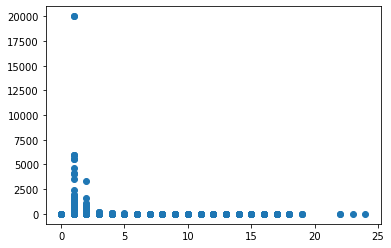

In [101]:
# Nombre de document pertinent en fonction du nombre de terme de la requete
tmp = {k: (len(topics[k]), len({kd: s for kd, s in t if s > 0.9}))
       for k, t in query2relevance.items()}
tmp = [(a, b) for a, b in tmp.values()]
plt.scatter([e[0] for e in tmp], [e[1] for e in tmp])
plt.show()

In [39]:
import seaborn as sns

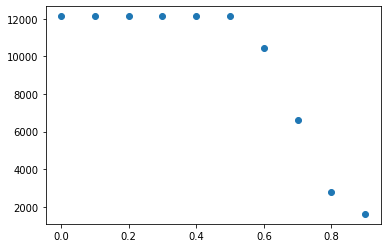

In [107]:
import numpy as np
# En fonction du seuil quel est le nombre de requetes qui retourne au moins 1 document ?
tmp = [(seuil, sum([sum(s > seuil for k_d, s in t if k_d != k) > 0 for k, t in query2relevance.items()]))
       for seuil in np.arange(0, 1, 0.1)]
plt.scatter(x=[e[0] for e in tmp], y=[e[1] for e in tmp])
plt.show()

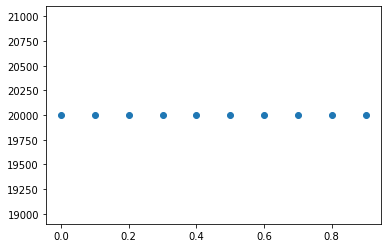

In [108]:
# En fonction du seuil combien de document lié a au moins 1 requetes
tmp = []
for seuil in np.arange(0., 1, 0.1):
    doc_freq = Counter()
    for k_q, t in query2relevance.items():
        # Docs ok avec la requete k_q
        doc_freq.update([k for k, s in t if s > seuil])
    tmp.append((seuil, len(doc_freq)))
plt.scatter([e[0] for e in tmp], [e[1] for e in tmp])
plt.show()

## Etude du TF max des termes

En fait les termes les plus fréquents n'apparraissent que pour 5% max des requetes donc c'est ok pas de filtrage.

In [109]:
from collections import Counter
# Est-ce que le DF peut être superieur à 1 ?
tmp = {t_id: {w: df for w, df in Counter(t).items() if df > 4} for t_id, t in topics.items()}
{k: v for k, v in tmp.items() if v}

{'021118': {'center': 6, 'dot': 5}}

In [110]:
voc = {}
for v in topics.values():
    for t in set(map(str.lower, v)): # set car il peut y avoir plusieurs fois le même terme dans une requete
        if t not in voc:
            voc[t] = 0
        voc[t] += 1

In [111]:
sorted([(t, f, f / len(topics)*100) for t, f in voc.items()], key=lambda x: x[1], reverse=True)

[('analysis', 1149, 5.745),
 ('networks', 1041, 5.205),
 ('systems', 997, 4.984999999999999),
 ('model', 965, 4.825),
 ('system', 806, 4.03),
 ('data', 753, 3.765),
 ('approach', 728, 3.64),
 ('design', 706, 3.53),
 ('method', 702, 3.51),
 ('algorithm', 695, 3.4750000000000005),
 ('control', 530, 2.65),
 ('information', 516, 2.58),
 ('network', 505, 2.5250000000000004),
 ('optimization', 457, 2.2849999999999997),
 ('models', 456, 2.2800000000000002),
 ('fuzzy', 453, 2.265),
 ('dynamic', 402, 2.01),
 ('new', 402, 2.01),
 ('application', 401, 2.005),
 ('performance', 400, 2.0),
 ('problem', 389, 1.9449999999999998),
 ('wireless', 382, 1.91),
 ('image', 376, 1.8800000000000001),
 ('detection', 373, 1.865),
 ('applications', 366, 1.83),
 ('algorithms', 354, 1.77),
 ('efficient', 347, 1.735),
 ('study', 340, 1.7000000000000002),
 ('problems', 337, 1.685),
 ('neural', 323, 1.6150000000000002),
 ('evaluation', 320, 1.6),
 ('simulation', 316, 1.58),
 ('adaptive', 313, 1.5650000000000002),
 ('m

In [136]:
%%time
tmp = [doc2content(d) for d in data.values()]
df = {t: sum(t in d for d in tmp) for t in list(voc.keys())}

CPU times: user 4min 56s, sys: 39.7 ms, total: 4min 56s
Wall time: 4min 56s


In [137]:
import re

In [161]:
%%time
tmp = [doc2content(data[d]) for d in sorted(data)]
esc = lambda t: t.replace('\\', '\\\\').replace('(', '\(').replace(')', '\)').replace('*', '\*').replace('+', '\+').replace('?', '\?').replace('[', '\[').replace(']', '\]')
esc_voc = list(map(esc, sorted(voc)))

tf = [[(len(re.findall(t, d))) for t in esc_voc] for d in tmp]

CPU times: user 3h 25min 44s, sys: 1.85 s, total: 3h 25min 46s
Wall time: 3h 25min 46s


In [ ]:
voc  # tf
df   # df
[voc[t] / len() for t in voc]